# Concept
- Concept: 
    - Webpage where shifter/shift leader can input 
        - The run they want to find a good reference run for
        - Basic requirements for their reference run
        - The runs that they want to consider as candidate reference runs
        - The features they want to be considered in the ranking process
        - Other advanced options
            - Number of components in PCA (default = 2)
            - Min number of LSs (default = 600)
            - Extra filters on candidate runs
    - Output is a table with
        - Candidate runs ordered by ranking
        - Number of LSs of each run
        - Quick link to OMS and GUI
        - Value of selected features
    - Run number of candidate runs is clickable and clicking it opens a side window which contains the following for the run
        - In/Out components
        - Full OMS metadata
        - Certification notes left by shifter (fetched form Cert Helper)
        - Summary plots
        - Search results for the selected run number (elogs might not have proper API to be able to do this)
- UI sketch

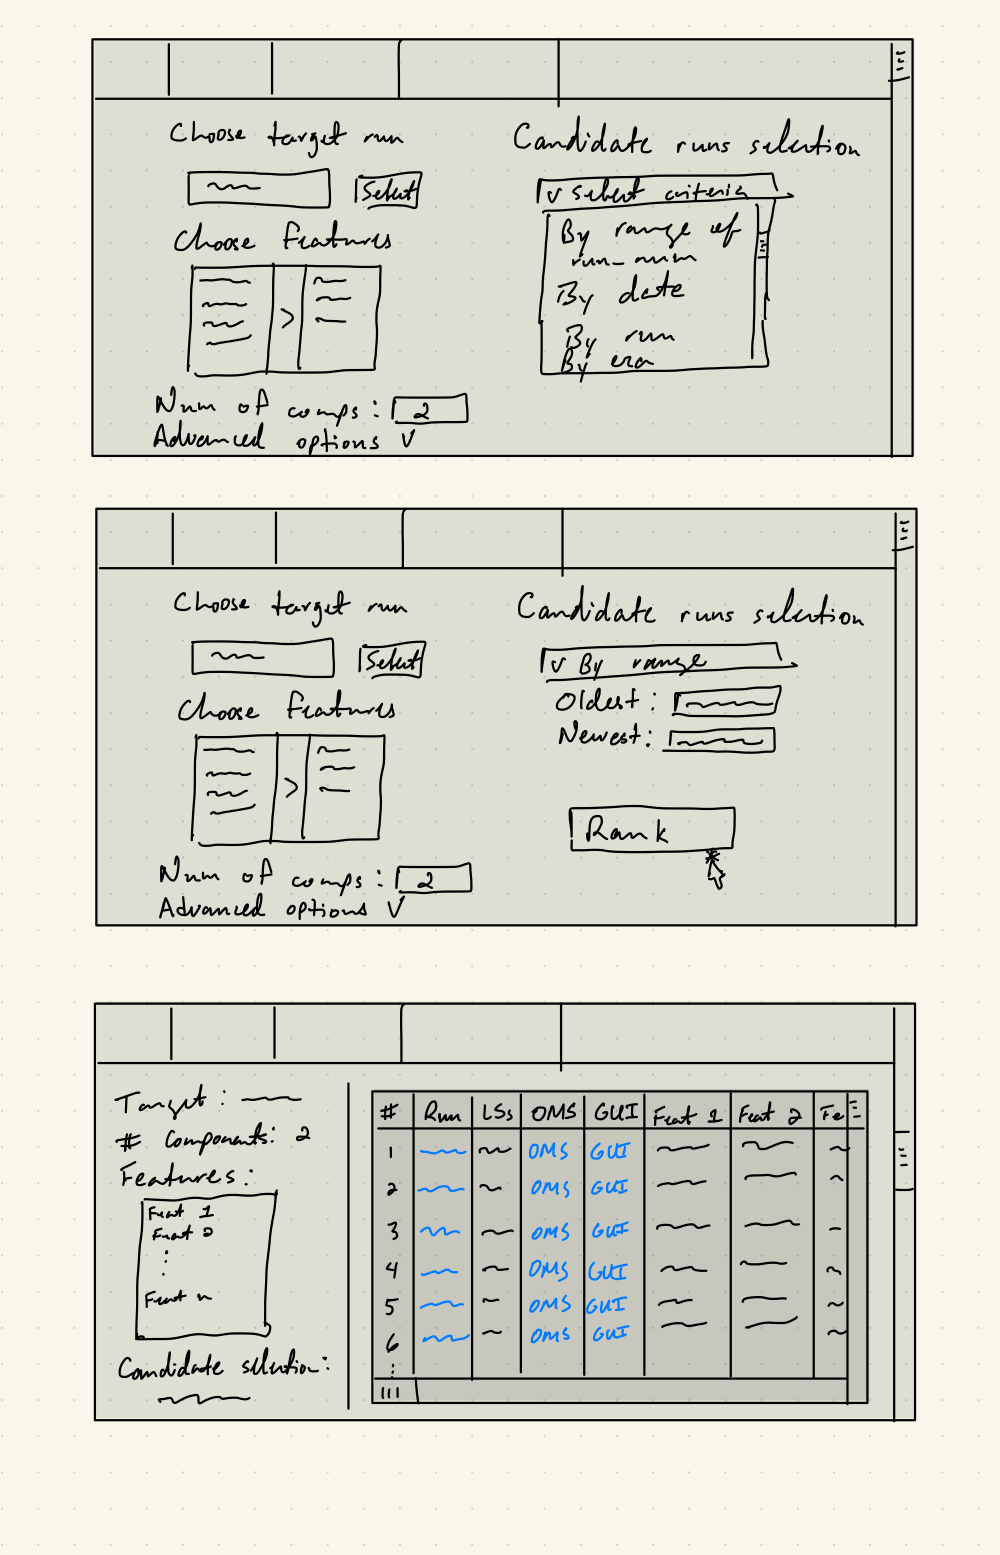

# Setup

In [ ]:
# External modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import importlib
import numpy as np
import os, sys
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../utils/'))

# Local modules
import get_oms_data
from get_oms_data import get_oms_api, get_oms_data, get_oms_response_attribute

import json_utils as jsonu
import plot_utils as pu

import mplhep as hep
hep.style.use("CMS")

import json_utils
from refruns_utils import get_reference_run as RRfetch
import refrank_utils as rrr
import oms_utils as omsu

pd.options.mode.chained_assignment = None

In [ ]:
importlib.reload(rrr)
importlib.reload(omsu)

In [ ]:
pd.options.mode.chained_assignment = None

# User Input
(Note: Implementation will first focus on only run level info. LS level info will be used afterwards as an optional enhancement in the ranking)
- Full selection of run level and LS level features

In [ ]:
# Initializing oms api
omsapi = get_oms_api()

In [ ]:
# Using the API, you can check all of the available features
print("All available run level features:\n")
get_oms_data(omsapi, "runs", 316201, limit_entries=1)["data"][0]["attributes"]

In [ ]:
print("All available LS level features:\n")
get_oms_data(omsapi, "lumisections", 316201, limit_entries=1)["data"][0]["attributes"]

In [ ]:
# Full feature list
fullftr_lst = [
    'components',
    'l1_hlt_mode_stripped',
    'l1_key',
    'duration',
    'b_field',
    'tier0_transfer',
    'l1_triggers_counter',
    'hlt_physics_throughput',
    'init_lumi',
    'era',
    'last_update',
    'components_out',
    'beamactive_total_deadtime',
    'recorded_lumi',
    'delivered_lumi',
    'cmssw_version',
    'crossing_angle_stop',
    'energy',
    'end_lumi',
    'hlt_physics_rate',
    'fill_number',
    'l1_hlt_mode',
    'end_time',
    'trigger_mode',
    'l1_key_stripped',
    'crossing_angle_start',
    'fill_type_party2',
    'fill_type_party1',
    'beta_star_start',
    'initial_prescale_index',
    'sequence',
    'start_time',
    'hlt_physics_size',
    'fill_type_runtime',
    'hlt_key',
    'clock_type',
    'last_lumisection_number',
    'l1_rate',
    'l1_menu',
    'run_number',
    'stable_beam',
    'beta_star_stop',
    'hlt_physics_counter'
]

In [ ]:
# Numeric features, compatible with PCA
# Comment out features you don't want considered
ftrs_lst = [
    'b_field',
#     'l1_triggers_counter',
#     'hlt_physics_throughput',
    'init_lumi',
#     'beamactive_total_deadtime',
#     'recorded_lumi',
#     'delivered_lumi',
#     'crossing_angle_stop',
    'energy',
    'end_lumi',
    'hlt_physics_rate',
#     'crossing_angle_start',
#     'beta_star_start',
#     'initial_prescale_index',
#     'hlt_physics_size',
    'l1_rate',
    'run_number',
#     'beta_star_stop',
#     'hlt_physics_counter',
    'fill_number', # Included for filtering
    'last_lumisection_number', # Not for ranking
    'duration', # Not for ranking
    "l1_hlt_mode" # Included for filtering
]

In [ ]:
target = 326189

In [ ]:
candidate_selection = "run_range"

if candidate_selection == "run_range":
    oldest_run = int(input("Oldest run: ")) # Suggestion: 308800
    newest_run = int(input("Newest run: ")) # Suggestion: 326201
    run_range = (oldest_run, newest_run)
elif candidate_selection == "range_range":
    pass
elif candidate_selection == "runs":
    pass
elif candidate_selection == "date":
    pass
elif candidate_selection == "era":
    pass

In [ ]:
# Number of PCA components
num_components = 2

# Runs used in ranking will need to have at least this run quality score
quality_thrshld = 0.75

# Features used will have to have weights that add up to at least this number
weight_thrshld = 1

# Features that have a correlation higher than this with another feature will be dropped
corr_thrshld = 1

In [ ]:
# Filters that will be applied in query
run_filters = [
    {"attribute_name": "l1_hlt_mode", "value": "collisions", "operator": "LIKE"}, # Only collision runs
    {"attribute_name": "last_lumisection_number", "value": 500, "operator": "GE"}
]

# Fetching Data

In [ ]:
# Fetching runs that will be used as candidates
candidates_df = omsu.download_oms_data(run_range, omsapi, "runs", ftrs_lst, extrafilters=run_filters).drop(columns=["index"])

# Filtering run
candidates_df = rrr.filter_runs(candidates_df, "json_TRK_PromptReco_2018Runs.json", "collisions2018")

# Creating a run number index column as an identifier of each run. Note that this is not being treated as a feature the same way run_number is
candidates_df["run"] = candidates_df["run_number"]
candidates_df.set_index("run", inplace=True)

# Removing any non-numeric features left
candidates_df = candidates_df.select_dtypes(["number"])

# Making index column integer type
candidates_df.index = candidates_df.index.astype(int)

candidates_df

In [ ]:
######## For testing, we also get all of the runs in the selected range. #########
targets_df = omsu.download_oms_data(run_range, omsapi, "runs", ftrs_lst, extrafilters=[run_filters[0]]).drop(columns=["index"])

targets_df = rrr.filter_runs(targets_df, "json_TRK_PromptReco_2018Runs.json", "collisions2018")

# Creating a run number index column as an identifier of each run. Note that this is not being treated as a feature the same way run_number is
targets_df["run"] = targets_df["run_number"]
targets_df.set_index("run", inplace=True)

# Removing any non-numeric features left
targets_df = targets_df.select_dtypes(["number"])

# Making index column type int
targets_df.index = targets_df.index.astype(int)

targets_df

In [ ]:
# Saving to parquet just in case
candidates_df.to_parquet(path="../data/candidates.parquet")
targets_df.to_parquet(path="../data/targets.parquet")

In [ ]:
# Loading from parquet
candidates_df = pd.read_parquet(path="../data/candidates.parquet")
targets_df.to_parquet(path="../data/targets.parquet")

In [ ]:
######### Quick check of the loaded runs and LSs #########
print("Number of candidate runs: {}".format(len(candidates_df)))
print("Number of target runs:    {}".format(len(targets_df)))

# Weight & Ranking

In [ ]:
# Out of the selected features, now we remove those features that are too correlated with another & 
# are "not imporant enough" as defined by the weight_thrshld
candidates_df = rrr.lowcorr_highweight(candidates_df, corr_thrshld, weight_thrshld)

# Adding reference run used column
RRs_used_candidates = candidates_df.reset_index()["run"].apply(lambda x: RRfetch(x, jsonfile="/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json"))
candidates_df["RR_used"] = RRs_used_candidates.values
candidates_df

In [ ]:
# Adding RR used column to targets
RRs_used_targets = targets_df.reset_index()["run"].apply(lambda x: RRfetch(x, jsonfile="/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json"))
targets_df["RR_used"] = RRs_used_targets.values

##### In order to properly test our ranking system, we get the refrank used for each target, and filter those available
targets_wRR = targets_df[(targets_df["RR_used"] != -1) & (targets_df["RR_used"].isin(rankings.reset_index()["run"]))]
targets_wRR

In [ ]:
def refrank(target_df, candidates_df, n_components=2):

    rankings, wghts = rrr.refrank_pca(target_df.iloc[:,:-4], candidates_df.iloc[:,:-4], n_components=n_components)
    rankings = rankings.merge(targets_df.iloc[:,-4:], left_index=True, right_index=True)

    # Add a new 'rank' column with a range of values starting from 0
    rankings['rank'] = range(len(rankings))

    # Set both 'rank' and 'run' as indices
    rankings = rankings.reset_index().set_index(['rank', 'run'])

    # Construct a new dictionary mapping original column names to 'name (weight)' format
    new_column_names = {original: f"{original} ({round(wght, 4)})" for original, wght in wghts.items()}

    # Rename the columns using the new dictionary
    rankings.rename(columns=new_column_names, inplace=True)

    return rankings

In [ ]:
target_df = pd.DataFrame(targets_wRR.iloc[0]).T
candidates_df.loc[:target_df.index[0]]

In [ ]:
# Testing ranking system
target_df = pd.DataFrame(targets_wRR.iloc[0]).T

rankings = refrank(target_df, candidates_df.loc[:target_df.index[0]-1], n_components=2) # Remember: .loc is inclusive
rankings

In [ ]:
# Finding the rank of the actual RR used
RR_used = rankings.iloc[0]["RR_used"]
rankings[rankings.index.get_level_values("run") == RR_used]

In [ ]:
from numpy import trapz

def test_rank(targets, candidates, comp_number=60, n_components=2, print_stats=True, plot=True, dpi=150, return_RRranks=True):
    """
    Iterates over a set of given target runs and performs PCA ranking. Then performs statistics on the results by evaluating 
    the rank that the actual reference run of each target run got.
    """
    
    RRresults = {"runs":[], "RRs": [], "ranks": []}
    
    for i, (index, row) in enumerate(targets_wRR.iterrows()):
        target_df = pd.DataFrame(row).T
        candidates = candidates_df.loc[:target_df.index[0]-1]
        if len(candidates) > comp_number:
            rank_df = refrank(target_df, candidates_df.loc[:target_df.index[0] - 1].iloc[-comp_number:], n_components=2)
            RR_used = rank_df.iloc[0]["RR_used"]
        else:
#             print("Not enough candidates. Skipping.")
            continue

        try: 
            actualRR_rank = rank_df[rank_df.index.get_level_values("run") == RR_used].index[0][0]
            RRresults["runs"].append(index)
            RRresults["RRs"].append(RR_used)
            RRresults["ranks"].append(actualRR_rank)
        except:
            continue
#             print("Failed to fetch actual RR used")
    
    RRresults = pd.DataFrame(RRresults)
    RRresults.sort_values("ranks", inplace=True)
    
    if print_stats:
        # Lower mean rank indicates better performance
        print("Mean rank of actual RR: {}".format(np.mean(RRresults["ranks"])))
        # Less sensitive to outliers than mean rank, better idea of central tendency
        print("Median rank of actual RR: {}".format(np.median(RRresults["ranks"])))
        # Measures how often actual RR appears withing top-k ranks
        print("Top-k accuracy (k=10): {}".format(sum(rank < 10 for rank in RRresults["ranks"]) / len(RRresults["ranks"])))
        # Stat measure for evaluating processes that produce a list of possible responses to a sample of queries, ordered by probability of correctness. 
        # Its the average of the reciprocal ranks of results for a sample of queries
        print("Mean reciprocal rank: {}".format(np.mean([1.0 / (rank + 1) for rank in RRresults["ranks"]])))
        
        # Making CDF plot
        
        RRranks_sorted = RRresults["ranks"].to_numpy()
        
        x_normalized = RRranks_sorted / RRranks_sorted.max()
        cdf = np.arange(1, len(RRranks_sorted) + 1) / len(RRranks_sorted)
        
        auc = trapz(cdf, x_normalized)
        
        plt.plot(RRranks_sorted, cdf)
        plt.xlabel("Rank of Actual RR")
        plt.ylabel("CDF")
        plt.title("CDF of Ranks of Actual RRs")
        plt.text(0.95, 0.05, f"AUC (normalized): {auc:.2f}", ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=0.5))
        plt.grid(True)
        plt.show()
    
    fig, ax = plt.subplots(dpi=dpi)
    ax.hist(RRresults["ranks"], bins=25)
    ax.set_title("RRR results for n={}, comparison_num={}".format(n_components, comp_number))
    ax.set_xlabel("Rank of actual reference run")

    ax.axvline(x=10, color="r", linestyle="--", linewidth=2)

    plt.show()
    
    if return_RRranks:
        return RRresults.reset_index().drop("index", axis=1)
    

In [ ]:
comp_number = 60
n_components = 2

RRranks = test_rank(targets_wRR, candidates, comp_number=comp_number, n_components=n_components, print_stats=True, plot=True, dpi=100, return_RRranks=True)